# Krylov complexity in quantum reservoir computing

The goal of this notebook is to calculate the Krylov complexity in different families of quantum reservoirs, which have different complexity according to the majorization criterion. We have observed that, in small Hilbert spaces, the distribution of the Unitaries in the Pauli space is different for each family. In this way, the families with higher complexity span the Pauli space uniformly, while those with lower complexity span only a subspace of the Pauli space.

Our aim is to show that the krylov complexity is able to capture this difference in complexity.

In [1]:
import numpy as np
from scipy import linalg,exp, cos, sin
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from functions_d import *
from lanczos import *
from quantum_reservoirs import *
import pandas as pd
import random
import itertools
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## 1. Complexity of a random unitary

We plot the complexity of a given family (G1, G2, G3, D2, D3, Dn, MG) in time. We also plot the values of the Krylov coefficients "a" and "b". The plots are made for different samples, which randomly generate the quantum reservoirs ffrom the given family.

We can see that we get fairly different results with the G1/G2 family compared to the other families. This indicates the difference in complexity of such families.

Unitaries calculated!


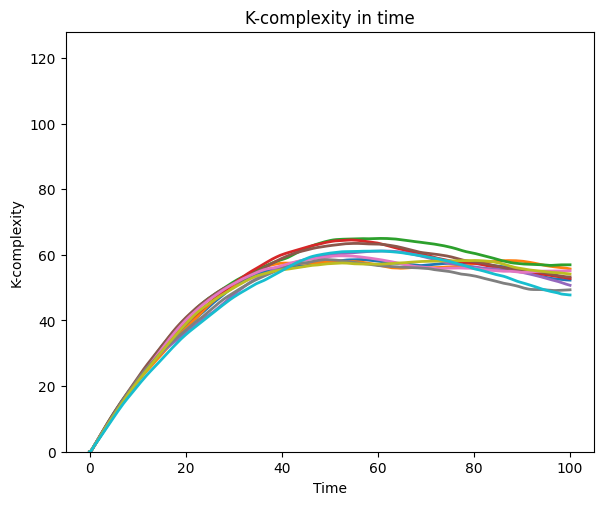

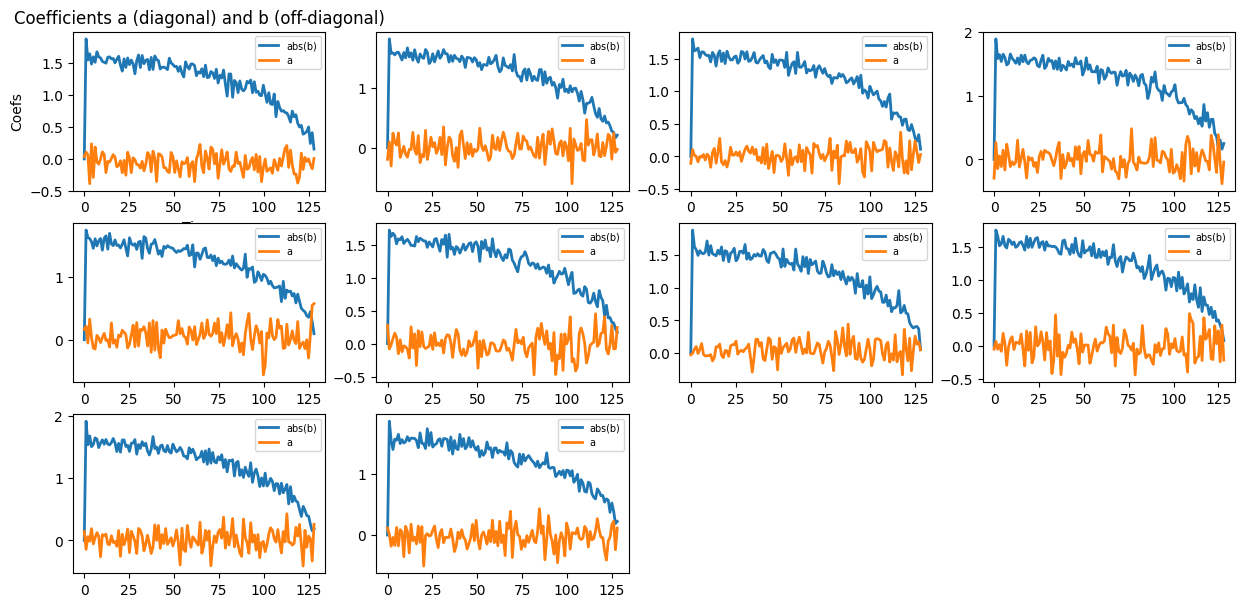

In [6]:
nqbits = 7
n = 2**nqbits
family = 'MG'
depth = 20
num_gates = depth*nqbits
num_samples = 10
tmax = 100


Us,_ = pauli_group_span(family, nqbits=nqbits, num_samples=num_samples, num_gates = num_gates)
print('Unitaries calculated!')
varia=[] # Variance b
varia2=[] # Variance b with respect to the mean
varia3=[] # variance a
varia4=[] # Variance b with respect to the mean discarding the first values
mea=[] # Mean value k-complexity
complexity = []
chaos = []

# Initial state
ff=np.zeros(n)#np.random.rand(n)#np.ones(n)##np.array([1,0,0,1])*1/np.sqrt(2)
ff[0] = 1  
ff=ff/np.sqrt(np.matmul(ff,ff))


for i in range(num_samples):
    # Get Hamiltonian as the logarith of the unitary
    F=-1j*linalg.logm(Us[i])

    ei=np.sort(np.real(linalg.eigvals(F)))
    chaos.append(r_chaometer(ei,False))

    # Get off-diagonal coefficients b
    a,b,c=FO_state(F,ff)

    #print(F.shape, ff.shape, b_arr.shape, a2.shape)
    # Get K-complexity
    x,y=k_complexity(a,b, tmax, ntimes=500)


    # Plot the Krylov complexity in time
    plt.figure(29,figsize=(15,12))
    plt.subplot(2,2, 1)
    plt.ylim([0,n])
    plt.plot(x,np.real(y),linewidth=2)#,label=k0)
    plt.title('K-complexity in time')
    plt.xlabel('Time')
    plt.ylabel('K-complexity')

    ################################################
    complexity.append(y)
    varia.append(np.var(b))
    mea.append(np.mean(np.real(y[100:])))
    varia3.append(np.var(a))  
    ################################################    


    # Plot the diagonal and non-diagonal coefficients of the Krylov basis a, b
    x1=np.linspace(0.,len(b),len(b))
    plt.figure(40,figsize=(15,12))
    plt.subplot(5, 4, i+1)
    plt.plot(x1,b,linewidth=2,label='abs(b)')
    plt.plot(x1,np.real(a),linewidth=2,label='a')
    plt.legend(loc='best',fontsize = 'x-small')
    if i==0:
        plt.title('Coefficients a (diagonal) and b (off-diagonal)')
        plt.xlabel('Time')
        plt.ylabel('Coefs')



    df = pd.DataFrame({'B': b})

    yy=df.rolling(window=10).std()
    yycut=yy[10:]
    xxcut=x1[10:]

    varia2.append(yycut.mean().iloc[0])

    df = pd.DataFrame({'B': np.real(a)})

    yy=df.rolling(window=10).std()
    yycut=yy[10:]
    xxcut=x1[10:]

    varia4.append(yycut.mean().iloc[0])


## Calculate the complexity of different unitaries

Now we calculate the mean complexity, the variance of the mean complexity, the variance of a and b and the mean value of r (Chaos), for the seven families of unitaries.

We can change the size of the Hilbert space (nqbits) and the initial state. 

In [7]:
num_samples = 100
nqbits = 7 # You can change the number of qubits here
depth = 40
num_gates = depth*nqbits
n=2**nqbits # Dimension of the Hilbert space
tmax=200. # Maximum time for the Hamiltonian evolution

# Initial state: 
num_initial_states = 1#40 # You can change this to perform different experiments changing the initial state
comp_basis = np.random.choice(n, num_initial_states, replace=False)

families = ['G1', 'G2', 'G3', 'MG', 'D2', 'D3', 'Dn']


In [21]:
complexity = []
a_vals = []
b_vals = []
chaos_vals = []
var_mean_comp = []

for family in tqdm(families):
    Us,_ = pauli_group_span(family, nqbits=nqbits, num_samples=num_samples, num_gates = num_gates)
    comp = []
    av = []
    bv = []
    chaosv = []
    varmean = []
    for j in range(num_initial_states):
        ff=np.zeros(n)#np.ones(n)##np.random.rand(n)
        ff[0] = 1  #comp_basis[j]
        ff=ff/np.sqrt(np.matmul(ff,ff))
        varia3=[] # variance a
        varia4=[] # Variance b with respect to the mean discarding the first values
        mea=[] # Mean value k-complexity
        chaos = []
        vm = []
        for i in range(num_samples):
            # Get Hamiltonian as the logarith of the unitary
            F=-1j*linalg.logm(Us[i])

            # Get coefficients , b
            a,b,c=FO_state(F,ff)
            ei=np.sort(np.real(linalg.eigvals(F)))

            # Get K-complexity
            x,y=k_complexity(a,b, tmax, ntimes=500)
            if y[-1]>500:
                continue
            
            #size_b.append(len(b)) 
            chaos.append(r_chaometer(ei,False))
            mea.append(np.mean(np.real(y[-300:]))) # Discard the first values to compute the complexity
            vm.append(np.nanvar(np.real(y[-300:]))/np.nanmean(np.real(y[-300:])))

            # Comptute the variance of a with respect to the mean
            x1=np.linspace(0.,len(a),len(a))
            df = pd.DataFrame({'B': a})
            yy=df.rolling(window=10).std()
            yycut=yy[10:]
            xxcut=x1[10:]
            varia3.append(yycut.mean().iloc[0])

            # Comptute the variance of b with respect to the mean
            x1=np.linspace(0.,len(b),len(b))
            df = pd.DataFrame({'B': b})
            yy=df.rolling(window=10).std()
            yycut=yy[10:]
            xxcut=x1[10:]
            varia4.append(yycut.mean().iloc[0])
        
    
        av.append(varia3)
        bv.append(varia4)
        comp.append(mea)
        chaosv.append(chaos)
        varmean.append(vm)
        
    complexity.append(comp)
    a_vals.append(av)
    b_vals.append(bv)
    chaos_vals.append(chaosv)
    var_mean_comp.append(varmean)

complexity = np.array(complexity)
a_vals = np.array(a_vals)
b_vals = np.array(b_vals)
chaos_vals = np.array(chaos_vals)
var_mean_comp =np.array(var_mean_comp)


  0%|          | 0/7 [00:00<?, ?it/s]

logm result may be inaccurate, approximate err = 0.3841052444090663
logm result may be inaccurate, approximate err = 0.006298330018957562
logm result may be inaccurate, approximate err = 0.03306616473271656
logm result may be inaccurate, approximate err = 0.005683105006987828


 14%|█▍        | 1/7 [07:44<46:27, 464.56s/it]

logm result may be inaccurate, approximate err = 0.0020900291420720045


100%|██████████| 7/7 [55:09<00:00, 472.81s/it]


In [369]:
with open('results/complexity_7qbits.npy', 'wb') as f:
    np.save(f, complexity)

with open('results/a_7qbits.npy', 'wb') as f:
    np.save(f, a_vals)

with open('results/b_7qbits.npy', 'wb') as f:
    np.save(f, b_vals)

with open('results/chaos_7qbits.npy', 'wb') as f:
    np.save(f, chaos_vals)

### Plot the metrics varying the initial state

The next plot shows the impact of the initial condition on the statistics of the family. We observe that varying the initial condition does not change much the results.
In this case, we use 7 qubits, 50 initial conditions and 50 samples of the unitary.

In [2]:
with open('results/complexity_7qbits.npy', 'rb') as f:
    complexity = np.load(f)

with open('results/a_7qbits.npy', 'rb') as f:
    a_vals = np.load(f)

with open('results/b_7qbits.npy', 'rb') as f:
    b_vals = np.load(f)

with open('results/chaos_7qbits.npy', 'rb') as f:
    chaos_vals = np.load(f)

In [3]:
mean_comp = np.nanmean(complexity, axis=(1,2))
var_comp = np.nanmean(np.nanvar(complexity, axis=(2)), axis=(1))
var_mean_comp = np.nanmean(np.nanvar(complexity, axis=(2))/np.nanmean(complexity, axis = (2)), axis=(1))
variance_a = np.nanmean(np.nanvar(a_vals, axis=(2)), axis=(1))
variance_b = np.nanmean(np.nanvar(b_vals, axis=(2)), axis=(1))
mean_chaos = np.nanmean(chaos_vals, axis=(1,2))
var_chaos = np.nanmean(np.var(chaos_vals, axis=(2)), axis=(1))


C:\Users\laiad\AppData\Local\Temp\ipykernel_11084\3229230172.py:7: RuntimeWarning: Mean of empty slice
  var_chaos = np.nanmean(np.var(chaos_vals, axis=(2)), axis=(1))


In [4]:
mean_comp2 = np.nanmean(complexity, axis=(2))
var_comp2 = np.nanvar(complexity, axis=(2))
var_mean_comp2 = np.nanvar(complexity, axis=(2))/np.nanmean(complexity, axis = (2))
variance_a2 = np.nanvar(a_vals, axis=(2))
variance_b2 = np.nanvar(b_vals, axis=(2))
mean_chaos2 = np.nanmean(chaos_vals, axis=(2))
var_chaos2 = np.var(chaos_vals, axis=(2))

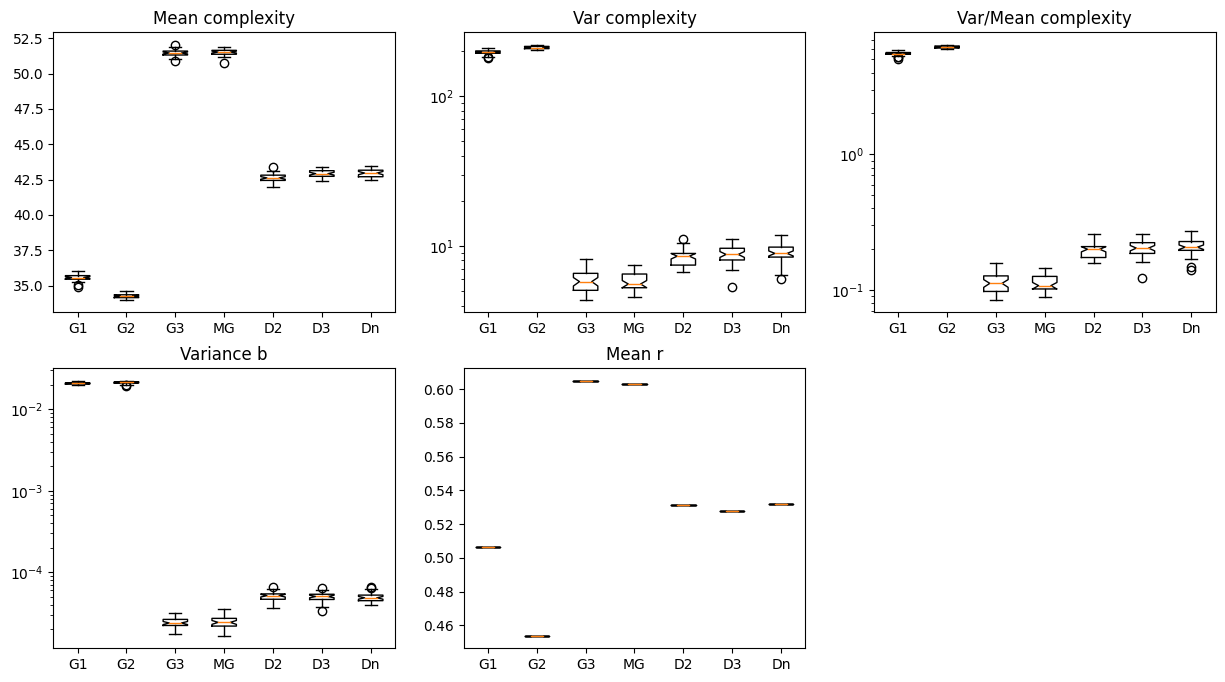

In [494]:
colors = ['blue', 'tomato', 'turquoise', 'purple', 'yellow', 'orange', 'gray']
mses = [0.000689, 0.000565, 0.000001, 0.000002,  0.000024, 0.000004, 0.000004]
families = ['G1', 'G2',  'G3', 'MG', 'D2', 'D3', 'Dn']
fig, ax = plt.subplots(2,3, figsize=(15,8))
#for i in range(mean_comp2.shape[1]):
    #ax[0][0].boxplot(families, mean_comp2[:,i], 'o')
ax[0][0].boxplot( mean_comp2.T, 'o')
ax[0][0].set_xticklabels(families)
ax[0][0].set_title('Mean complexity')

ax[0][1].boxplot( var_comp2.T, 'o')
ax[0][1].set_xticklabels(families)
ax[0][1].set_yscale('log')
ax[0][1].set_title('Var complexity')

ax[0][2].boxplot( var_mean_comp2.T, 'o')
ax[0][2].set_xticklabels(families)
ax[0][2].set_title('Var/Mean complexity')
ax[0][2].set_yscale('log')

ax[1][0].boxplot( variance_b2.T, 'o')
ax[1][0].set_xticklabels(families)
ax[1][0].set_yscale('log')
ax[1][0].set_title('Variance b')

ax[1][1].boxplot( mean_chaos2.T, 'o')
ax[1][1].set_xticklabels(families)
ax[1][1].set_title('Mean r')

ax[1][2].remove()

plt.show()


### Visualize the results for different number of qubits

Now let's visualize all the results alltogether, for different number of qubits.

In [8]:
with open('results/mean_comp_10qbits_ones.npy', 'rb') as f:
    mean_comp10 = np.load(f)
with open('results/var_comp_10qbits_ones.npy', 'rb') as f:
    var_comp10 = np.load(f)
with open('results/var_a_10qbits_ones.npy', 'rb') as f:
    variance_a10 = np.load(f)
with open('results/var_b_10qbits_ones.npy', 'rb') as f:
    variance_b10 = np.load(f)
with open('results/mean_chaos_10qbits_ones.npy', 'rb') as f:
    mean_chaos10 = np.load(f)

with open('results/mean_comp_9qbits_ones.npy', 'rb') as f:
    mean_comp9 = np.load(f)
with open('results/var_comp_9qbits_ones.npy', 'rb') as f:
    var_comp9 = np.load(f)
with open('results/var_a_9qbits_ones.npy', 'rb') as f:
    variance_a9 = np.load(f)
with open('results/var_b_9qbits_ones.npy', 'rb') as f:
    variance_b9 = np.load(f)
with open('results/mean_chaos_9qbits_ones.npy', 'rb') as f:
    mean_chaos9 = np.load(f)

with open('results/mean_comp_8qbits_ones.npy', 'rb') as f:
    mean_comp8 = np.load(f)
with open('results/var_comp_8qbits_ones.npy', 'rb') as f:
    var_comp8 = np.load(f)
with open('results/var_a_8qbits_ones.npy', 'rb') as f:
    variance_a8 = np.load(f)
with open('results/var_b_8qbits_ones.npy', 'rb') as f:
    variance_b8 = np.load(f)
with open('results/mean_chaos_8qbits_ones.npy', 'rb') as f:
    mean_chaos8 = np.load(f)

with open('results/mean_comp_7qbits_ones.npy', 'rb') as f:
    mean_comp7 = np.load(f)
with open('results/var_comp_7qbits_ones.npy', 'rb') as f:
    var_comp7 = np.load(f)
with open('results/var_a_7qbits_ones.npy', 'rb') as f:
    variance_a7 = np.load(f)
with open('results/var_b_7qbits_ones.npy', 'rb') as f:
    variance_b7 = np.load(f)
with open('results/mean_chaos_7qbits_ones.npy', 'rb') as f:
    mean_chaos7 = np.load(f)

with open('results/mean_comp_6qbits_ones.npy', 'rb') as f:
    mean_comp6 = np.load(f)
with open('results/var_comp_6qbits_ones.npy', 'rb') as f:
    var_comp6 = np.load(f)
with open('results/var_a_6qbits_ones.npy', 'rb') as f:
    variance_a6 = np.load(f)
with open('results/var_b_6qbits_ones.npy', 'rb') as f:
    variance_b6 = np.load(f)
with open('results/mean_chaos_6qbits_ones.npy', 'rb') as f:
    mean_chaos6 = np.load(f)



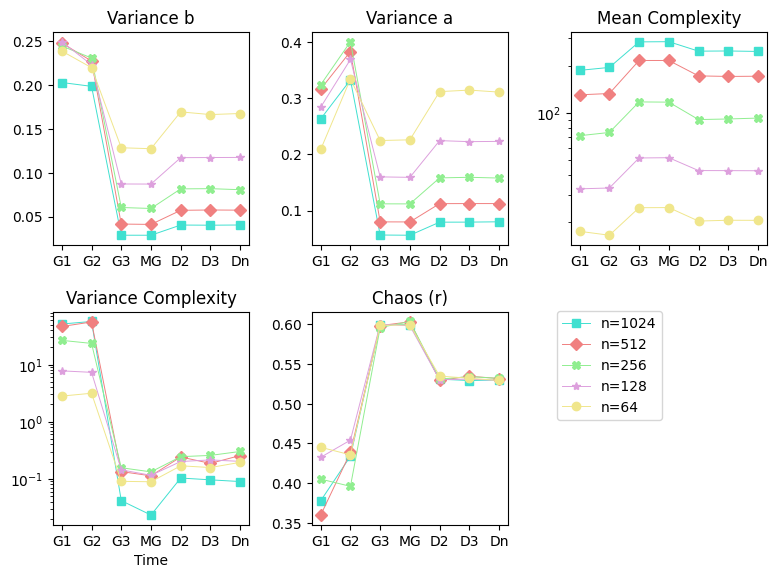

In [9]:
fig, ax = plt.subplots(2,3, figsize=(8,6))

ax[0][0].plot(families, variance_b10, marker = 's', linewidth=0.7, color='turquoise')
ax[0][0].plot(families, variance_b9, marker = 'D', linewidth=0.7, color='lightcoral')
ax[0][0].plot(families, variance_b8, marker = 'X', linewidth=0.7, color='lightgreen')
ax[0][0].plot(families, variance_b7, marker = '*', linewidth=0.7, color='plum')
ax[0][0].plot(families, variance_b6, marker = 'o', linewidth=0.7, color='khaki')
ax[0][0].set_title('Variance b')


ax[0][1].plot(families, variance_a10, marker = 's', linewidth=0.7, color='turquoise')
ax[0][1].plot(families, variance_a9, marker = 'D', linewidth=0.7, color='lightcoral')
ax[0][1].plot(families, variance_a8, marker = 'X', linewidth=0.7, color='lightgreen')
ax[0][1].plot(families, variance_a7, marker = '*', linewidth=0.7, color='plum')
ax[0][1].plot(families, variance_a6, marker = 'o', linewidth=0.7, color='khaki')
ax[0][1].set_title('Variance a')


ax[0][2].plot(families, mean_comp10,  marker = 's', linewidth=0.7,color='turquoise')
ax[0][2].plot(families, mean_comp9,  marker = 'D', linewidth=0.7,color='lightcoral')
ax[0][2].plot(families, mean_comp8,  marker = 'X', linewidth=0.7,color='lightgreen')
ax[0][2].plot(families, mean_comp7,  marker = '*', linewidth=0.7,color='plum')
ax[0][2].plot(families, mean_comp6,  marker = 'o', linewidth=0.7,color='khaki')
ax[0][2].set_yscale('log')
ax[0][2].set_title('Mean Complexity')


ax[1][0].plot(families, var_comp10/mean_comp10,  marker = 's', linewidth=0.7,color='turquoise')
ax[1][0].plot(families, var_comp9/mean_comp9,  marker = 'D', linewidth=0.7,color='lightcoral')
ax[1][0].plot(families, var_comp8/mean_comp8,  marker = 'X', linewidth=0.7,color='lightgreen')
ax[1][0].plot(families, var_comp7/mean_comp7,  marker = '*', linewidth=0.7,color='plum')
ax[1][0].plot(families, var_comp6/mean_comp6,  marker = 'o', linewidth=0.7,color='khaki')
ax[1][0].set_yscale('log')
ax[1][0].set_title('Variance Complexity')
ax[1][0].set_xlabel('Time')

ax[1][1].plot(families, mean_chaos10, marker = 's', linewidth=0.7,color='turquoise', label='n=1024')
ax[1][1].plot(families, mean_chaos9, marker = 'D', linewidth=0.7,color='lightcoral', label='n=512')
ax[1][1].plot(families, mean_chaos8, marker = 'X', linewidth=0.7,color='lightgreen', label='n=256')
ax[1][1].plot(families, mean_chaos7, marker = '*', linewidth=0.7,color='plum', label='n=128')
ax[1][1].plot(families, mean_chaos6, marker = 'o', linewidth=0.7,color='khaki', label='n=64')
ax[1][1].set_title('Chaos (r)')
handles, labels = ax[1][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.85,0.27))

ax[1][2].remove()
fig.tight_layout(pad=1.5)


### Plots for the paper

Here you can see the exact figures shown in the paper.

Text(-0.2, 4000, '(b)')

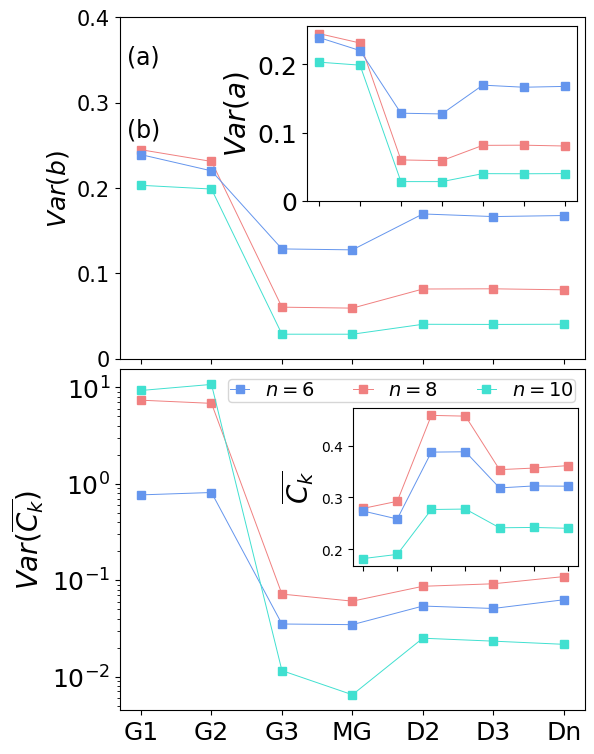

In [18]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, (ax1, ax3)= plt.subplots(2,1, figsize=(6,9), height_ratios=[1,1])
plt.subplots_adjust(hspace=0.03)

ax1.plot(families, variance_b10, marker = 's', linewidth=0.7, color='turquoise')
ax1.plot(families, variance_b8, marker = 's', linewidth=0.7, color='lightcoral')
ax1.plot(families, variance_b6, marker = 's', linewidth=0.7, color='cornflowerblue')

ax1.set_yticks([0,0.1,0.2,0.3, 0.4], [0,0.1,0.2,0.3, 0.4], fontsize=15)
ax1.set_ylabel(r'$Var(b)$', fontsize=18)
ax1.tick_params(labelbottom=False) 

ax2 = inset_axes(ax1, width="45%", height="50%",loc=2, bbox_to_anchor = (255,440,600,350))
ax2.plot(families, variance_b10, marker = 's', linewidth=0.7, color='turquoise')
ax2.plot(families, variance_b8, marker = 's', linewidth=0.7, color='lightcoral')
ax2.plot(families, variance_b6, marker = 's', linewidth=0.7, color='cornflowerblue')
ax2.set_yticks([0,0.1,0.2], [0,0.1,0.2], fontsize=18)
ax2.set_ylabel(r'$Var(a)$', fontsize=20)
#ax2.set_xticks([ ], [ ], fontsize=14)
ax2.tick_params(labelbottom=False) 


ax3.plot(families, var_comp6/2**6,  marker = 's', linewidth=0.7, color='cornflowerblue',label=r'$n=6$')
ax3.plot(families, var_comp8/2**8,  marker = 's', linewidth=0.7,color='lightcoral',label=r'$n=8$')
ax3.plot(families, var_comp10/2**10,  marker = 's', linewidth=0.7, color='turquoise',label=r'$n=10$')

ax3.set_xticks(families, families, fontsize=18)
#ax3.set_yticks([0,40,80,120], [0,40,80,120], fontsize=15)
ax3.set_ylabel(r'$Var(\overline{C_k})$', fontsize=20)
ax3.legend(fontsize=14, ncols=3, handlelength=1, borderpad=0.1, labelspacing=0.1)
ax3.tick_params(axis='y', which='major', labelsize=18)
ax3.set_yscale('log')

ax4 = inset_axes(ax3, width="45%", height="45%", loc=1,  bbox_to_anchor = (40,58,500,350))
ax4.plot(families, mean_comp10/2**10,  marker = 's', linewidth=0.7, color='turquoise')
ax4.plot(families, mean_comp8/2**8,  marker = 's', linewidth=0.7, color='lightcoral')
ax4.plot(families, mean_comp6/2**6,  marker = 's', linewidth=0.7, color='cornflowerblue')
ax4.set_ylabel(r'$\overline{C_k}$', fontsize=20)
ax4.tick_params(labelbottom=False)   
#ax4.set_yticks([0, 100, 200, 300 ], [0, 100, 200, 300  ], fontsize=16)


ax1.text(-0.2,0.345, '(a)', fontsize=17)
ax3.text(-0.2, 4000, '(b)', fontsize=17)

Text(-0.2, 0.565, '(b)')

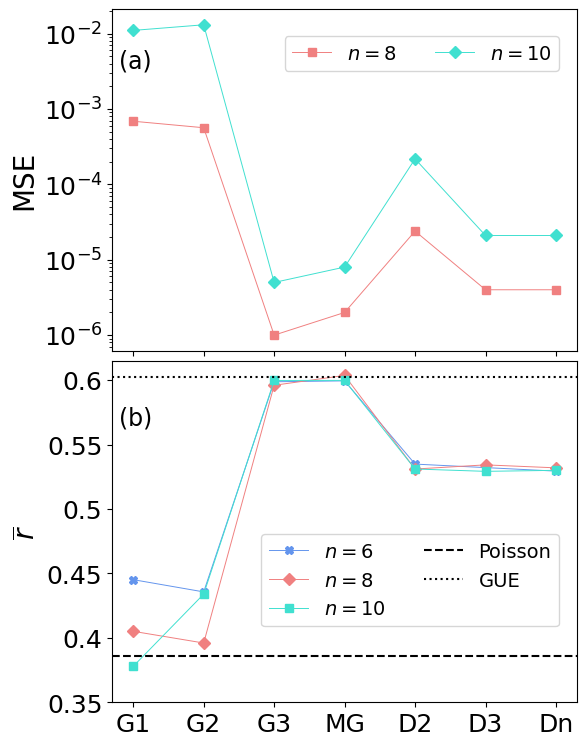

In [35]:
mses1 = [0.000689, 0.000565, 0.000001, 0.000002,  0.000024, 0.000004, 0.000004] #Delta E1 (LiH)
mses2 = [0.000962, 0.001085, 0.000004, 0.000042, 0.000042, 0.000010, 0.000007] # Delta E2 (LiH)
mses3 = [0.011052, 0.013118, 0.000005, 0.000008, 0.000218, 0.000021, 0.000021] # Delta E1 (H2O)

fig, (ax1, ax2)= plt.subplots(2,1, figsize=(6,9), height_ratios=[1,1])
plt.subplots_adjust(hspace=0.03)

ax1.plot(families, mses1, color='lightcoral', marker = 's', linewidth=0.7, label=r'$n = 8$')
ax1.plot(families, mses3, color='turquoise', marker = 'D', linewidth=0.7, label=r'$n = 10$')
ax1.set_ylabel(r'MSE', fontsize=20)
ax1.tick_params(labelbottom=False) 
ax1.tick_params(axis='y', which='major', labelsize=18)
ax1.set_yscale('log')
ax1.legend(bbox_to_anchor=(0.35, 0.95),
           fontsize=14, ncols=2)


ax2.plot(families, mean_chaos6, color='cornflowerblue', marker = 'X', linewidth=0.7, label=r'$n = 6$')
ax2.plot(families, mean_chaos8, color='lightcoral', marker = 'D', linewidth=0.7, label=r'$n = 8$')
ax2.plot(families, mean_chaos10, color='turquoise', marker = 's', linewidth=0.7, label=r'$n = 10$')
ax2.axhline(y=0.38629, linestyle='dashed', color='black', label='Poisson')
ax2.axhline(y=0.60266, linestyle='dotted', color='black', label='GUE')
ax2.set_ylabel(r'$\overline{r}$', fontsize=20)
ax2.set_xticks(families, families, fontsize=18)
ax2.set_yticks([0.35,0.4,0.45, 0.5, 0.55, 0.6], [0.35,0.4,0.45, 0.5, 0.55, 0.6], fontsize=18)
ax2.legend(bbox_to_anchor=(0.3, 0.52),
           fontsize=14, ncols=2)

ax1.text(-0.2,3.5e-3,'(a)', fontsize=17)
ax2.text(-0.2,0.565,'(b)', fontsize=17)